Time to Load Notebook: approximate (25min)

## Question: Can we create a system to check if text was written by AI?

## Data Question: Can we create a model to classify AI generated text vs human generated text?

<div style="text-align: center;color: blue;">
    <h1>Imports</h1>
</div>

In [1]:
#!pip install plotly
#!pip install wordcloud

In [2]:
import numpy as np
import pandas as pd

import string
import spacy

from collections import Counter

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, confusion_matrix

<div style="text-align: center;color: blue;">
    <h1>EDA</h1>
</div>

### Loading in Data

In [3]:
df = pd.read_csv('AI_Human.csv')

### Sampling Data

In [4]:
df = df.sample(n=10000, random_state=1)
df.reset_index(drop=True)

,text,generated
0,"STUDENT_NAME\n\ndear, TEACHER_NAME\n\nI believ...",0.0
1,"Dear Senator,\n\nI am writing to you today to ...",1.0
2,It is crucial for students to begin consideri...,1.0
3,The way the author supported his claims were w...,0.0
4,"If you have an issue, speaking to more than on...",0.0
...,...,...
9995,Attend classes from home via online videoconfe...,1.0
9996,"As an 8tQ grader, I believe that finishing Hig...",1.0
9997,"Title: Exploring Venus\n\nVenus, the second pl...",1.0
9998,"Hey there! So, I was like, thinking about how...",1.0


### Inspecting Data

In [5]:
df.shape

(10000, 2)

In [6]:
df.head()

,text,generated
400655,"STUDENT_NAME\n\ndear, TEACHER_NAME\n\nI believ...",0.0
434717,"Dear Senator,\n\nI am writing to you today to ...",1.0
418486,It is crucial for students to begin consideri...,1.0
417354,The way the author supported his claims were w...,0.0
304380,"If you have an issue, speaking to more than on...",0.0


In [7]:
df.describe()

,generated
count,10000.000000
mean,0.371900
std,0.483336
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [8]:
df = df.rename(columns={'generated': 'Label', 'text': 'Text'}) # Renaming Cols

In [9]:
df['Label'].value_counts() # about a 60/40 split

Label
0.0    6281
1.0    3719
Name: count, dtype: int64

In [10]:
df['Label'].isna().sum() # no na values

0

In [11]:
df.dtypes

Text      object
Label    float64
dtype: object

### Changing Label to int

In [12]:
df['Label'] = df['Label'].astype(int)

In [13]:
df.head()

,Text,Label
400655,"STUDENT_NAME\n\ndear, TEACHER_NAME\n\nI believ...",0
434717,"Dear Senator,\n\nI am writing to you today to ...",1
418486,It is crucial for students to begin consideri...,1
417354,The way the author supported his claims were w...,0
304380,"If you have an issue, speaking to more than on...",0


### Class Distribution

In [104]:
df['Label'].value_counts()

Label
0    6281
1    3719
Name: count, dtype: int64

In [105]:
value_counts = { 'Student':6281, 'Ai':3719 }

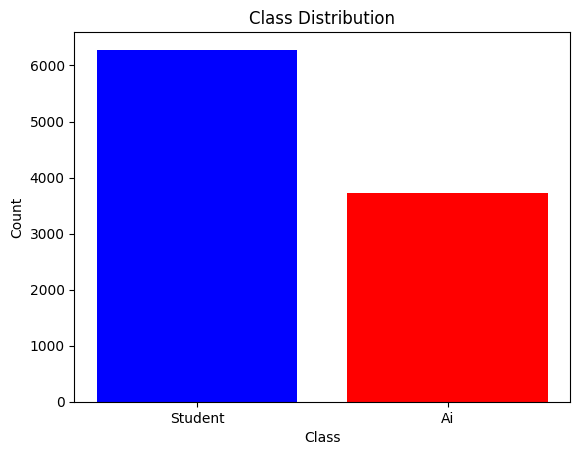

In [107]:
plt.bar(value_counts.keys(), value_counts.values(), color=['blue','red'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Visulising Text Length

In [14]:
length = df

In [125]:
length['text_length'] = length['Text'].apply(lambda x: len(x.split())) # adding a column for length of text 

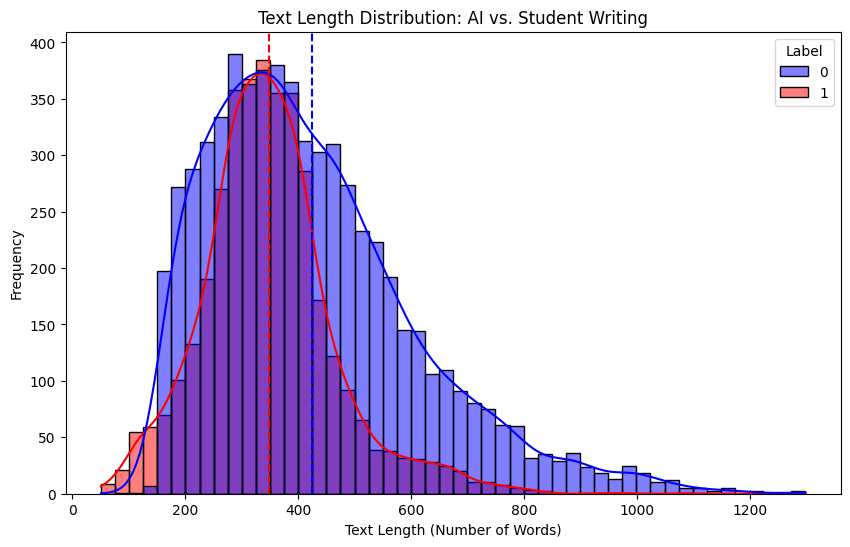

In [128]:
plt.figure(figsize=(10, 6)) 
sns.histplot(data=length, x='text_length', hue='Label', bins=50, kde=True, palette={0: 'blue', 1: 'red'})

means = length.groupby('Label')['text_length'].mean()

for label, mean_value in means.items():
    color = 'blue' if label == 0 else 'red'
    plt.axvline(mean_value, color=color, linestyle='--', label=f'Mean {label}: {mean_value:.2f}')

plt.title('Text Length Distribution: AI vs. Student Writing')
plt.xlabel('Text Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df.head()

### Visulising Most Common Words using Word Clouds

In [18]:
student_text = ' '.join(df[df['Label'] == 0]['Text']) # Joining all student text

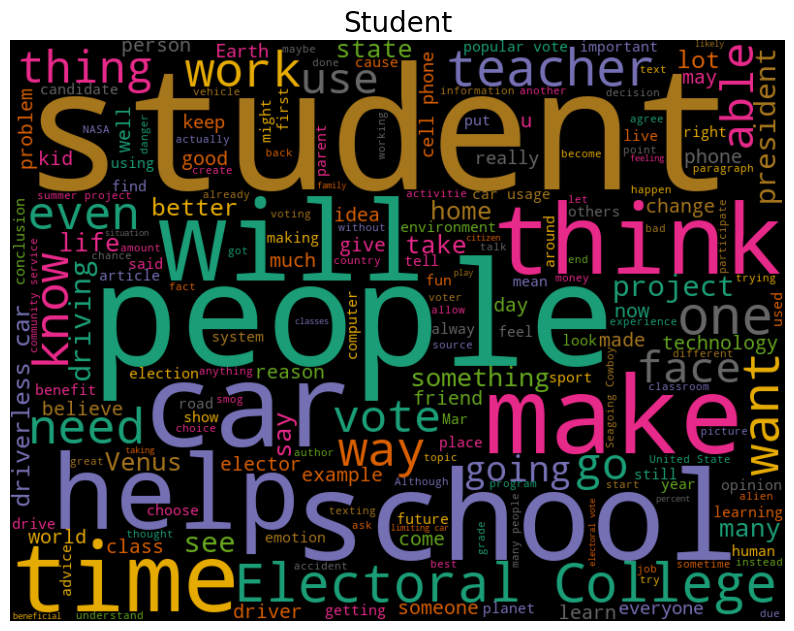

In [19]:
wordcloud = WordCloud(width=800, height=600, background_color='black', colormap='Dark2').generate(student_text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Student', fontsize=20)
plt.show()

In [20]:
ai_text = ' '.join(df[df['Label'] == 1]['Text']) # Joining all ai text

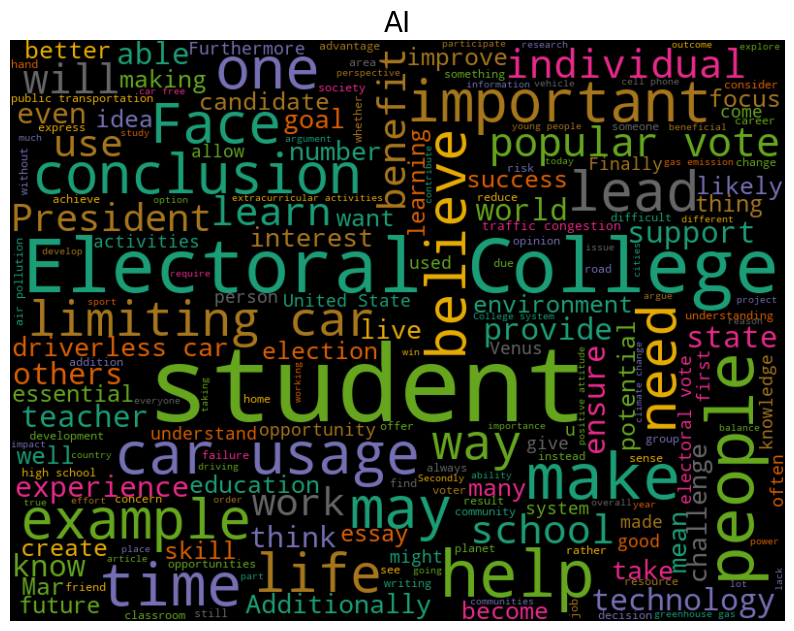

In [21]:
wordcloud = WordCloud(width=800, height=600, background_color='black', colormap='Dark2').generate(ai_text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('AI', fontsize=20)
plt.show()

<div style="text-align: center;color: blue;">
    <h1>Test Train Split</h1>
</div>

In [22]:
X = df.drop(columns=['Label', 'text_length']) # defining features
y = df['Label'] # defining target

In [23]:
X.head()

,Text
400655,"STUDENT_NAME\n\ndear, TEACHER_NAME\n\nI believ..."
434717,"Dear Senator,\n\nI am writing to you today to ..."
418486,It is crucial for students to begin consideri...
417354,The way the author supported his claims were w...
304380,"If you have an issue, speaking to more than on..."


In [24]:
y.head()

400655    0
434717    1
418486    1
417354    0
304380    0
Name: Label, dtype: int32

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # using test train split to train and test models

<div style="text-align: center;color: blue;">
    <h1>Removing Stopwords</h1>
</div>

In [26]:
X_train.head()

,Text
297382,Summer projects are what most students dread d...
129489,"Just think about, you in a new place. Somewher..."
337178,"I think we can keep it, But improve it. Like s..."
184632,Everyone has different opinions. These opinion...
247792,"Okay, here's MJ attempt at writing an essay as..."


In [27]:
vectorizer = CountVectorizer(stop_words='english')
stop_words = set(vectorizer.get_stop_words())
def remove_stopwords(text):
    if isinstance(text, str): 
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_words)
    return
X_train_cleaned = X_train['Text'].apply(remove_stopwords)
X_test_cleaned = X_test['Text'].apply(remove_stopwords)

In [28]:
X_train_cleaned

297382    Summer projects students dread break, necessar...
129489    Just think about, new place. before. Just Mari...
337178    think it, improve it. Like people want just vo...
184632    different opinions. opinions important comes s...
247792    Okay, here's MJ attempt writing essay average ...
                                ...                        
74089     opinion, Emerson's statement anything, wants w...
412181    electoral college America chooses president. e...
441763    navigated way medical mechanic workshops, dazz...
53755     schools let students design projects summer le...
199864    like join Seagoing Cowboys care animals boat. ...
Name: Text, Length: 8000, dtype: object

In [29]:
X_test_cleaned

108360    Driverless caps ape science fiction, fop years...
333611    school cop pitted promoting clean vibrant comm...
225232    Experience Adventure High Sea Seagoing Cowboy ...
187256    think "driverless cars" sounds impossible, rig...
236539    driverless cars alternative cars drivers. alte...
                                ...                        
332408    Dear [State Senator], writing Express opinion ...
413955    Using technology identify facial gestures unth...
18992     Taking classes home advantageous time-saving e...
170514    Limiting car usage important benefits communit...
75252     today's digital age, ability attend school hom...
Name: Text, Length: 2000, dtype: object

<div style="text-align: center;color: blue;">
    <h1>Feature Engineering</h1>
</div>

### Count Vectors

In [30]:
count_vect = CountVectorizer(token_pattern = r'\w{1,}')
count_vect.fit(X_train_cleaned)

CountVectorizer(token_pattern='\\w{1,}')

In [31]:
X_train_count = count_vect.transform(X_train_cleaned)
X_test_count = count_vect.transform(X_test_cleaned)

### TF-IDF Vectors

#### Single Words

In [32]:
%%time
tfidf_vect = TfidfVectorizer(analyzer = 'word', token_pattern = r'\w{1,}', max_features = 5000)

tfidf_vect.fit(X_train_cleaned)
X_train_tfidf = tfidf_vect.transform(X_train_cleaned)
X_test_tfidf  = tfidf_vect.transform(X_test_cleaned)

CPU times: total: 922 ms
Wall time: 1.32 s


#### Ngram Words (2-3)

In [33]:
%%time
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word', token_pattern = r'\w{1,}', ngram_range = (2, 2), max_features = 5000, stop_words='english')

tfidf_vect_ngram.fit(X_train_cleaned)
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train_cleaned)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test_cleaned)

CPU times: total: 1.81 s
Wall time: 3.37 s


#### Characters (2-3)

In [34]:
%%time
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer = 'char', ngram_range = (2, 3), max_features = 5000)

tfidf_vect_ngram_chars.fit(X_train_cleaned)
X_train_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_train_cleaned)
X_test_tfidf_ngram_chars  = tfidf_vect_ngram_chars.transform(X_test_cleaned)

CPU times: total: 7.95 s
Wall time: 12.6 s


In [214]:
X_train_tfidf_ngram_chars

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6857194 stored elements and shape (8000, 5000)>

### Topic Models

In [35]:
%%time

lda_model = LatentDirichletAllocation(n_components = 20, learning_method = 'online', max_iter = 20)

X_topics = lda_model.fit_transform(X_train_count)
topic_word = lda_model.components_
vocab = count_vect.get_feature_names_out()

CPU times: total: 25.6 s
Wall time: 44.8 s


In [36]:
n_top_words = 10
topic_summaries = []
print('Group Top Words')
print('-----', '-'*80)
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    top_words = ' '.join(topic_words)
    topic_summaries.append(top_words)
    print('  %3d %s' % (i, top_words))

Group Top Words
----- --------------------------------------------------------------------------------
    0 cars driving driverless car driver phone road drivers drive technology
    1 emotions facial technology computer action classroom facs expressions human coding
    2 use phones students cell technology phone school class using policy
    3 people t s like it just make think don help
    4 face mars natural landform just nasa aliens alien picture like
    5 students school student time learning work classes summer projects project
    6 tf tht ant ff surfing waves gf thu s fn
    7 tre r eo af tnd twe government rf eye snd
    8 thd tz zo iz oz tse ard azd z ans
    9 school sports activities kids activity average participate play b students
   10 important s potential provide skills additionally benefits lead education however
   11 seagoing program animals cowboys cowboy luke world join fun people
   12 success life positive goals attitude failure people important achieve s
   

#### Topic Models are used for single line predictions to help prompt ai models when writing essays

<div style="text-align: center;color: blue;">
    <h1>Modeling</h1>
</div>

### Function to Train Models

In [129]:
def train_model(classifier, vector_train, target_train, vector_test, param_grid):
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='f1_weighted', cv=5)
    grid_search.fit(vector_train, target_train)
    
    best_classifier = grid_search.best_estimator_
    best_classifier.fit(vector_train, target_train)
    
    predictions = best_classifier.predict(vector_test)
    
    return f1_score(y_test, predictions, average='weighted'), grid_search.best_params_

### Logistic Regression

In [130]:
param_grid_log = {
        'penalty': ['l2'],
        'C': [0.1, 1, 10],
        'solver': ['lbfgs'],
        'max_iter': [1000, 5000, 10000]
    }

In [131]:
%%time
F1_log = train_model(LogisticRegression(random_state=42), X_train_count, y_train, X_test_count, param_grid_log)

CPU times: total: 7.25 s
Wall time: 9.28 s


In [132]:
%%time
F1_log2 = train_model(LogisticRegression(random_state=42), X_train_tfidf, y_train, X_test_tfidf, param_grid_log)

CPU times: total: 766 ms
Wall time: 1.92 s


In [133]:
%%time
F1_log3 = train_model(LogisticRegression(random_state=42), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram, param_grid_log)

CPU times: total: 453 ms
Wall time: 1.31 s


In [134]:
%%time
F1_log4 = train_model(LogisticRegression(random_state=42), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars, param_grid_log)

CPU times: total: 5.12 s
Wall time: 14.9 s


### Naive Bays

In [135]:
param_grid_nb = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'fit_prior': [True, False]
}

In [136]:
%%time
F1_nb = train_model(MultinomialNB(), X_train_count, y_train, X_test_count, param_grid_nb)

CPU times: total: 156 ms
Wall time: 469 ms


In [137]:
%%time
F1_nb2 = train_model(MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, param_grid_nb)

CPU times: total: 109 ms
Wall time: 418 ms


In [138]:
%%time
F1_nb3 = train_model(MultinomialNB(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram, param_grid_nb)

CPU times: total: 93.8 ms
Wall time: 217 ms


In [139]:
%%time
F1_nb4 = train_model(MultinomialNB(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars, param_grid_nb)

CPU times: total: 891 ms
Wall time: 2.31 s


### Support Vector Machines (SVM)

In [140]:
param_grid_svm = {
    'C': [0.01, 0.1, 1],
    'class_weight': [None, 'balanced'],
    'max_iter': [5000, 20000],
}

In [141]:
%%time
F1_svm = train_model(LinearSVC(random_state=42), X_train_count, y_train, X_test_count, param_grid_svm)

CPU times: total: 3.12 s
Wall time: 8.08 s


In [142]:
%%time
F1_svm2 = train_model(LinearSVC(random_state=42), X_train_tfidf, y_train, X_test_tfidf, param_grid_svm)

CPU times: total: 906 ms
Wall time: 2.53 s


In [143]:
%%time
F1_svm3 = train_model(LinearSVC(random_state=42), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram, param_grid_svm)

CPU times: total: 219 ms
Wall time: 1.14 s


In [144]:
%%time
F1_svm4 = train_model(LinearSVC(random_state=42), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars, param_grid_svm)

CPU times: total: 6.31 s
Wall time: 26.9 s


### Bagging (Random Forests)

In [145]:
param_grid_rf = {
    'n_estimators': [100, 200],
} # runtime is long for these so I only added a few params

In [146]:
%%time
F1_bag = train_model(RandomForestClassifier(random_state=42), X_train_count, y_train, X_test_count, param_grid_rf)

CPU times: total: 21 s
Wall time: 1min 51s


In [147]:
%%time
F1_bag2 = train_model(RandomForestClassifier(random_state=42), X_train_tfidf, y_train, X_test_tfidf, param_grid_rf)

CPU times: total: 20.4 s
Wall time: 1min 9s


In [148]:
%%time
F1_bag3 = train_model(RandomForestClassifier(random_state=42), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram, param_grid_rf)

CPU times: total: 11.5 s
Wall time: 1min


In [149]:
%%time
#F1_bag4 = train_model(RandomForestClassifier(random_state=42), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars, param_grid_rf)
# Removed model as processing time reached 10min without completing 

CPU times: total: 0 ns
Wall time: 0 ns


### Boosting (Gradient)

In [150]:
param_grid_gb = {
    'n_estimators': [200],
    'learning_rate': [0.01, 0.1],
} # runtime is also long for these so I only added a few params

In [151]:
%%time
F1_boost = train_model(GradientBoostingClassifier(random_state=42), X_train_count, y_train, X_test_count, param_grid_gb)

CPU times: total: 1min 42s
Wall time: 7min 28s


In [152]:
%%time
F1_boost2 = train_model(GradientBoostingClassifier(random_state=42), X_train_tfidf, y_train, X_test_tfidf, param_grid_gb)

CPU times: total: 1min 32s
Wall time: 8min


In [153]:
%%time
F1_boost3 = train_model(GradientBoostingClassifier(random_state=42), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram, param_grid_gb)

CPU times: total: 45 s
Wall time: 2min 23s


In [154]:
%%time
#F1_boost4 = train_model(GradientBoostingClassifier(random_state=42), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars, param_grid_gb)
# Removed model as processing time reached 10min without completing 

CPU times: total: 0 ns
Wall time: 0 ns


<div style="text-align: center;color: blue;">
    <h1>Testing</h1>
</div>

### Results

In [155]:
results = pd.DataFrame(columns = ['Count Vectors', 'Words TF-IDF Vectors', 'N-Gram Vectors', 'Character Level Vectors'])

In [156]:
# Logistic Regression Results
results.loc['Logistic Regression'] = {
    'Count Vectors': F1_log[0],
    'Words TF-IDF Vectors': F1_log2[0],
    'N-Gram Vectors': F1_log3[0],
    'Character Level Vectors': F1_log4[0]}

In [157]:
# Naive Bayes Results
results.loc['Naïve Bayes'] = {
    'Count Vectors': F1_nb[0],
    'Words TF-IDF Vectors': F1_nb2[0],
    'N-Gram Vectors': F1_nb3[0],
    'Character Level Vectors': F1_nb4[0]}

In [158]:
# Support Vector Machines (SVM) Results
results.loc['Support Vector Machines'] = {
    'Count Vectors': F1_svm[0],
    'Words TF-IDF Vectors': F1_svm2[0],
    'N-Gram Vectors': F1_svm3[0],
    'Character Level Vectors': F1_svm4[0]}

In [159]:
# Bagging (Random Forests) Results
results.loc['Bagging (Random Forests)'] = {
    'Count Vectors': F1_bag[0],
    'Words TF-IDF Vectors': F1_bag2[0],
    'N-Gram Vectors': F1_bag3[0],
#    'Character Level Vectors': F1_bag4[0]
}

In [160]:
# Gradient Boosting Results
results.loc['Gradient Boosting'] = {
    'Count Vectors': F1_boost[0],
    'Words TF-IDF Vectors': F1_boost2[0],
    'N-Gram Vectors': F1_boost3[0],
    #'Character Level Vectors': F1_boost4[0]
}

In [161]:
results

,Count Vectors,Words TF-IDF Vectors,N-Gram Vectors,Character Level Vectors
Logistic Regression,0.979497,0.981455,0.973395,0.977963
Naïve Bayes,0.941802,0.935834,0.964980,0.922079
Support Vector Machines,0.979000,0.983982,0.973925,0.982010
Bagging (Random Forests),0.962166,0.968274,0.956012,NaN
Gradient Boosting,0.963286,0.959798,0.891967,NaN


### Model Averages

In [162]:
results['Average'] = results[['Count Vectors', 'Words TF-IDF Vectors', 'N-Gram Vectors', 'Character Level Vectors']].mean(axis=1)
results

,Count Vectors,Words TF-IDF Vectors,N-Gram Vectors,Character Level Vectors,Average
Logistic Regression,0.979497,0.981455,0.973395,0.977963,0.978077
Naïve Bayes,0.941802,0.935834,0.964980,0.922079,0.941174
Support Vector Machines,0.979000,0.983982,0.973925,0.982010,0.979729
Bagging (Random Forests),0.962166,0.968274,0.956012,NaN,0.962151
Gradient Boosting,0.963286,0.959798,0.891967,NaN,0.938350


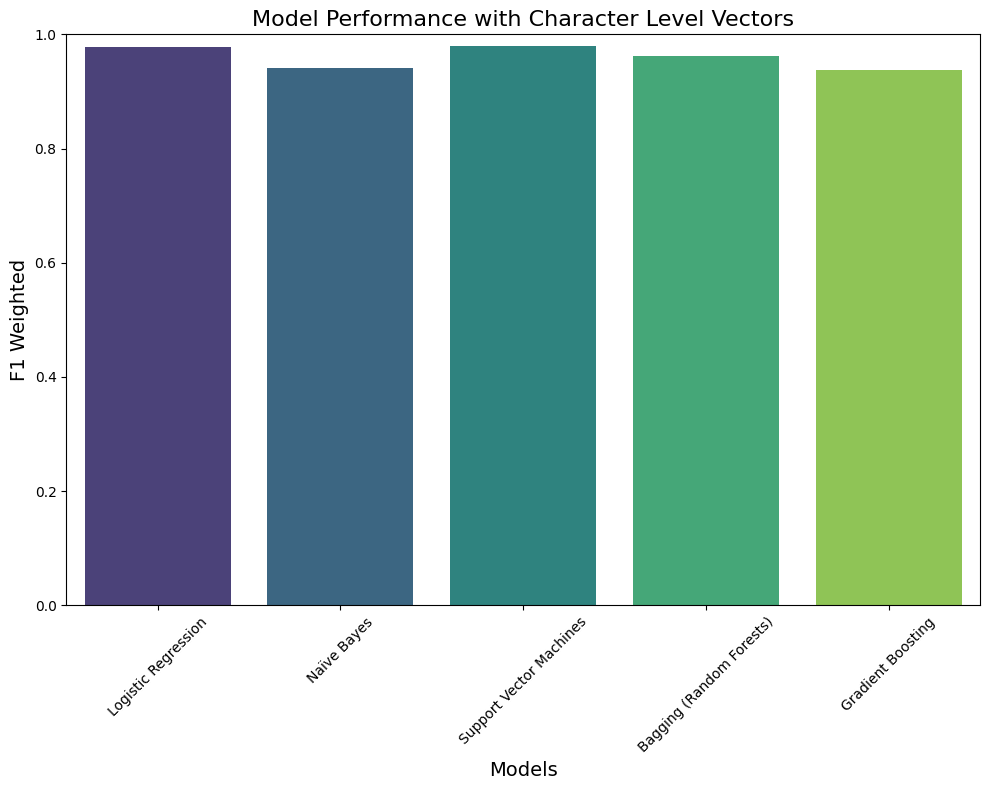

In [163]:
plt.figure(figsize=(10, 8))
sns.barplot(x=results.index, y='Average', data=results,  palette='viridis', hue=results.index)
plt.title('Model Performance with Character Level Vectors', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('F1 Weighted', fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Best Model Vectors

In [164]:
svm_scores = results.loc[results.index == 'Support Vector Machines'].iloc[0, 0:-1]
svm_scores

Count Vectors              0.979000
Words TF-IDF Vectors       0.983982
N-Gram Vectors             0.973925
Character Level Vectors    0.982010
Name: Support Vector Machines, dtype: float64

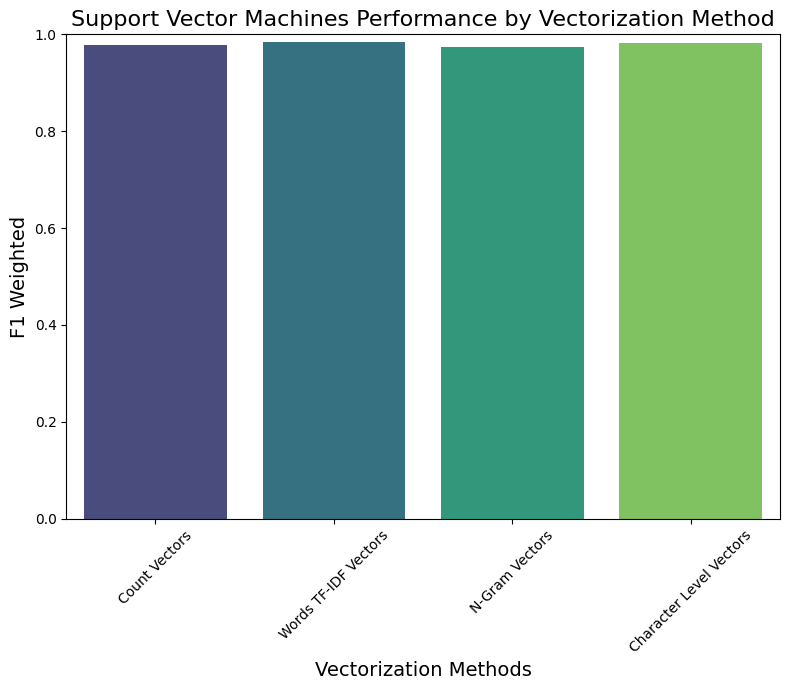

In [165]:
plt.figure(figsize=(8, 7))
sns.barplot(x=svm_scores.index, y=svm_scores, palette='viridis', hue=svm_scores.index)
plt.title('Support Vector Machines Performance by Vectorization Method', fontsize=16)
plt.xlabel('Vectorization Methods', fontsize=14)
plt.ylabel('F1 Weighted', fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div style="text-align: center;color: blue;">
    <h1>Best Model Testing and Scoring</h1>
</div>

### Training Best Model

In [74]:
F1_svm2[1]

{'C': 1, 'class_weight': 'balanced', 'max_iter': 5000}

In [75]:
model = LinearSVC(random_state=42, C=1, class_weight='balanced', max_iter=5000)
model.fit(X_train_tfidf, y_train)

LinearSVC(C=1, class_weight='balanced', max_iter=5000, random_state=42)

### Confusion Matrix

In [76]:
def train_model_predictions(classifier, vector_train, target_train, vector_test, param_grid):
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='f1', cv=5)
    grid_search.fit(vector_train, target_train)
    
    best_classifier = grid_search.best_estimator_
    best_classifier.fit(vector_train, target_train)
    
    predictions = best_classifier.predict(vector_test)
    
    return predictions

In [77]:
pred_log = train_model_predictions(LinearSVC(random_state=42), X_train_tfidf, y_train, X_test_tfidf, param_grid_svm)

In [78]:
cm_log = confusion_matrix(y_test, pred_log)

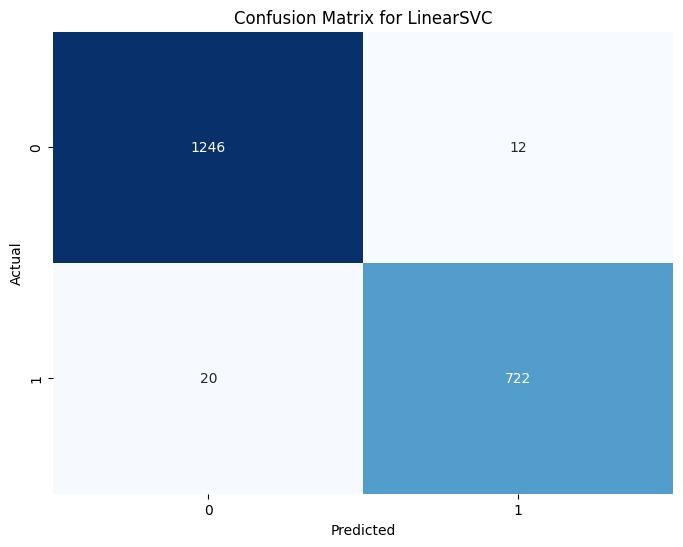

In [79]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LinearSVC')
plt.show()

### Single Line Predictions

In [80]:
def single_line_predictions(text, model):
    text = remove_stopwords(text)
    text_vec = tfidf_vect.transform([text])
    prediction = model.predict(text_vec)

    if prediction == 0:
        prediction = 'Student'
    else:
        prediction = 'Ai'
    
    return prediction

### Student Generated Essays

In [168]:
Joels_english_essay = "Cars have been by all means the number one way of  transportation in the last decade and now people are starting to prefer walking or biking instead of driving everywhere. One of the reasons is pollution people all around the world are scared of the greenhouse effect but peole are moslty looking at the advantages in not driving If we dont drive the earth will be less polluted in the united states the number two cause in pollution is cars if we cut our driving in half we would be making our earth less polluted and more clean and also saving our ozone layer another reason that not driving isnt such a nad thing is you dont have to deal with the gas money everyone spends on there car well if you want to drive you have to put gas in it so it can go and sometimes the gas prices can be up there an if i gave my estimate i think people spend close 20,000 dollars in gas if your driving in your community of course im not talking about every person in the world just giving an estimate and that is alot of money if you save that much money in about 4 years you have your self a house or an apratment its a big difference spending all that money on gas then saving up for something you really want like a house apartment etc something else you dont have to deal with is the traffic that cars cause on the higway and sometimes in the community i know we all have been stuck in a horrible traffic jam and you cant do anything about it and we all think if only we could just walk ny everybody well the people that arnet driving and they are on the sidewalk yeah they can walk past it or they dont have to deal with the traffic jam another reason is a the accidents sometimes can be fatal to life and your checkbook and insurance now a days is through the roof another thing you have to worry about paying when your dealing with a car accidents take alot of lives every year i read a stat that every second there areÂ  three acidents i mean i dont know if its true but if it is that is flat out scary of course you never think it will happen to you but even the best drivers crash and when it does happen either your life is in danger or checkbook is thats another thing walkers and bikers dont have to worry about crashing and either being seriously injured or coughing thousnads of dollars of expensies or damages also have to worry about keeping your car in the shop every time you need an oil change or your tires are flat or transmisson isnt working right there can be a millon problems with your car and that all cost money waling to your destantion doesnt cost a cent and if your the person that likes to save every cent why throw it away when you throwing thousands and thousands of dollars every year on something youn quite francally dont need in your life if your destnation is to walk take the bus close enough so you can walk there that way you will be saving so much money that you'l be amazed at the end of the year when you have wayÂ  more money than you had last year your going to look back and say wow i should never got a car so always keep in mind the next time you stepÂ  in your car the worries you deal with every time you drive remember ypu have to fill up or your not going any where and always going to hurt your checkbook espiacally if your car gets 10 per a gallon another thing isÂ  the scare of the accident always looming in the dark you never know when you'll have but almost everyone is doomed to have one and those can be fatal to your body or checkbook and insureance for when it does happen is not pretty also those traffic jams are horrible and when you say aabout 50 peole all past you on the side walk and your stuck in that massive traffic jam you'll remeber this essay and say wow i should of been on that side walk and the last advantge you should know about is that while your not driving your not hurting everyones earth world air space etc your helping the earth get cleaner everytime you decide to walk instead pump up your gas tank and let off polluted gas off into the air and ulitamelty deplete the ozone i know that people will still be driving because again like i said its the number one way of transportation but the goal should be to atleast cut the driving rate in half that would help the earth in a major way and of course you would be alot richer by the end of the year so all that walking you did over the year you can rechoice over a nice vaction to the bahmamas or hawaii oe even buy yourself a nice house so you can see that dropping your car should of been a decison you did years ago and the earth will be a better place without your car driving around the streets so the next time your friend asks to come over just walk or the next time you need to just go get the groroices you can walk and one by one peole will stop driving and start helping making the earth a better cleaner safer place so you be the first one to drop driving and start walking and people will follow imsure of it and even if you have to explain the benfits so beit just know by doing those things you will acheive the goal of making the earth a better place without pollution and more ozone layer to protect from the dangerous uv light if you want a better future for your kid or grandchild its just not your earth your hurting its everybody else's including your loved ones all that money your spending buy your loved ones a gift."

In [169]:
Joels_prediction_single = single_line_predictions(Joels_english_essay, model)
Joels_prediction_single

'Student'

In [170]:
Rileys_english_essay = """Dear grandpa For my English class this year I have had to read a book called “Grey Ghosts” by Deborah Challinor and then recommend it to someone. Deborah Challinor is a very talented author that has written many books in her career; a few are the Lenard girls, tamar and behind the sun. My book Gray Ghosts is about New Zealand vets and about their war experiences. I think this book will help you to know what your father was doing while you were growing up. Although you were only about 8 I think that you're brothers understood what was going on where you're father was. During this letter I will tell you why you should read this book. Firstly I will tell you how this book might help you understand you're dads feelings while he was fighting “The worst thing about being in a war is the feeling of helplessness. You're in a situation where you can't control anything, you're just waiting for something to happen." Jack a New Zealand infantryman. Although your father was only one of many that fought, all soldiers would have been like Jack. He would have been scared and uncertain what was gonna happen and if he would ever return home to his family and especially his children. But behind that uncertainty I think he felt one with all the soldiers, as I heard most of them felt the same. "We were fighting for our mates. You would do anything for them, because you knew they would do the same for you." Bob, a New Zealand infantryman. This quote expresses how your father may have felt with his fellow soldiers during the battles. He may not have felt safe but he didn't feel alone. Without your father there to support you and the rest of your family, I can only image how difficult it must have been. The veterans of the Vietnam War highlighted how valuable the care packages and letters were to them. We wrote letters home every day and received a lot of responses, but it may take up to two weeks for the mail to reach. I can only assume that the care packages served as a reminder to your father that his family is still waiting for his return. I was always appreciative of whatever I have. Once, I received a package from home that contained a bottle of Worcestershire sauce and some leftover meat. Heaven was there. Small gestures like that really cheer you up. This quotation truly The soldiers spoke about the issues they faced both during and after their duty, such as how fighting affected their mental and physical health and how difficult it was to return into society. They also spoke of the bonds they developed with their fellow soldiers and the feelings of purpose and brotherhood they had while serving. I wonder if your father ever found it difficult to come home or if he was just happy to be there."Returning home was the toughest challenge. You changed from being a part of a close-knit group to being merely another bystander on the street. You no longer felt a part of society. The veterans spoke about how hard it was for them to return back into society and during the war, such as how the war affected their mental health and their physical health and why those issues made it hard for them to return to society. They spoke about their bonds with their fellow soldiers and the brotherhood they made with their fellow soldiers during the vietnam war. I wonder if ur father struggled to return back home. "The biggest problem was coming home. You went from being a member of a tight-knit group to just another person on the street. You didn't feel part of society anymore."""

In [171]:
Rileys_prediction_single = single_line_predictions(Rileys_english_essay, model)
Rileys_prediction_single

'Student'

### Ai Generated Essays

In [85]:
Chat_gpt4_essay = "Literature has a unique way of illuminating the human experience, especially in times of conflict. Deborah Challinor’s novel “Grey Ghosts” offers a profound exploration of the lives of New Zealand veterans and the emotional and psychological impacts of war on soldiers and their families. Through the eyes of characters such as Jack and Bob, readers gain insight into the complexities of their experiences during and after the Vietnam War. This essay will delve into the themes of camaraderie, the struggle for identity post-war, and the importance of familial connections, illustrating how “Grey Ghosts” not only recounts the past but also highlights the ongoing struggles faced by veterans. One of the most significant themes in “Grey Ghosts” is the camaraderie shared among soldiers. Challinor beautifully illustrates the bonds formed in the midst of chaos, demonstrating how these relationships provide soldiers with a sense of purpose and belonging. Jack’s quote, “The worst thing about being in a war is the feeling of helplessness. You're in a situation where you can't control anything, you're just waiting for something to happen,” encapsulates the uncertainty faced by soldiers. Yet, amidst this uncertainty, the brotherhood becomes a source of strength. Bob’s words, “We were fighting for our mates. You would do anything for them, because you knew they would do the same for you,” reveal the profound loyalty and love that exist among comrades in arms. This sense of brotherhood is crucial for the soldiers as it mitigates feelings of isolation and fear. They rely on one another for emotional support, sharing their fears and hopes, and forming connections that transcend the battlefield. The notion that soldiers are willing to sacrifice for one another reflects a deeper understanding of their shared humanity. This theme resonates not only within the context of war but also speaks to the importance of community and connection in overcoming adversity. The transition from soldier to civilian life poses significant challenges for veterans, a theme that Challinor poignantly addresses in “Grey Ghosts.” The struggle for identity and the difficulty of reintegrating into society are common experiences for many veterans, and the novel captures this sentiment effectively. The quote, “Returning home was the toughest challenge. You changed from being a part of a close-knit group to being merely another bystander on the street. You no longer felt a part of society,” underscores the emotional turmoil faced by soldiers upon their return. This disconnect can lead to feelings of alienation and depression as veterans grapple with their experiences and the stark contrast between life on the battlefield and civilian life. The bonds they formed during the war are often not replicated in their home environments, leading to a sense of loneliness. Challinor sheds light on these challenges, providing readers with an understanding of the psychological struggles that veterans endure long after the war has ended. The impact of war extends beyond the soldiers themselves, affecting their families and loved ones. In “Grey Ghosts,” the importance of familial support becomes evident as characters navigate the challenges posed by the absence of their loved ones. The narrative captures the emotional strain placed on families who await the return of their fathers, brothers, and husbands. The text reflects on the letters and care packages sent to soldiers, serving as lifelines that remind them of their families and provide comfort amidst the chaos of war. Challinor’s portrayal of care packages highlights the small gestures that can uplift spirits during difficult times. The sentiment of appreciation for simple items, such as a bottle of Worcestershire sauce, illustrates how even the smallest reminders of home can have a significant impact. These connections help sustain soldiers emotionally, bridging the gap between the front lines and their loved ones back home. Moreover, the narrative prompts readers to consider the emotional toll on families who wait for their soldiers’ return. The uncertainty and anxiety experienced by family members can be overwhelming. The novel emphasizes that the emotional scars of war affect not only the veterans but also their loved ones, who must grapple with the changes that come with the soldier’s return. Challinor encourages readers to reflect on the sacrifices made by families during wartime, underscoring the need for empathy and understanding in supporting veterans and their families."

In [86]:
prediction_Chat_gpt_essay = single_line_predictions(Chat_gpt4_essay, model)
prediction_Chat_gpt_essay

'Ai'

In [87]:
Gemini_flash_essay = "The human mind, a complex tapestry woven from threads of thought, emotion, and experience, is a marvel of nature. It is the source of our creativity, our compassion, and our capacity for both great good and great evil. Yet, despite its extraordinary capabilities, the human mind is also prone to biases, fallacies, and cognitive distortions that can cloud our judgment and lead us astray. One of the most pervasive biases that afflicts the human mind is confirmation bias. This tendency to seek out information that confirms our preexisting beliefs while dismissing or downplaying evidence that contradicts them is deeply ingrained in our psychology. Confirmation bias can manifest in a variety of ways, from selective exposure to information to the tendency to interpret ambiguous evidence in a way that supports our preconceptions. For example, a person who believes in astrology may be more likely to remember instances where astrological predictions came true while forgetting or downplaying instances where they were inaccurate. Another common cognitive distortion is the availability heuristic, which refers to the tendency to judge the likelihood of an event based on how easily examples of it come to mind. This bias can lead us to overestimate the frequency of rare but memorable events while underestimating the frequency of common but less salient ones. For instance, people may overestimate the risk of plane crashes because they are vividly reported in the news, while underestimating the risk of car accidents, which are far more common but less attention-grabbing. The halo effect is another cognitive bias that can distort our perceptions of others. This phenomenon occurs when we form a positive or negative impression of a person based on a single positive or negative trait, and then project that impression onto other aspects of their personality. For example, a person who is physically attractive may be perceived as more intelligent, competent, and trustworthy than someone who is less attractive. The human mind is also susceptible to a variety of fallacies, including the false dichotomy, which involves presenting a complex issue as if there were only two possible options, and the slippery slope, which argues that a particular action will inevitably lead to a chain of negative consequences. These fallacies can be used to manipulate public opinion and undermine rational discourse. In addition to these cognitive biases and fallacies, the human mind is also influenced by our emotions. Emotions can play a powerful role in shaping our beliefs and behaviors, and can sometimes lead us to make irrational decisions. For example, fear can cause us to overestimate the risk of certain threats, while anger can impair our judgment and make us more likely to engage in impulsive actions. Despite these limitations, the human mind remains a remarkable instrument. By understanding our cognitive biases, fallacies, and emotional influences, we can become more aware of our own limitations and make more informed and rational decisions. Moreover, by cultivating critical thinking skills and developing a healthy skepticism, we can protect ourselves from the manipulation and misinformation that abound in the world today. In conclusion, the human mind is a complex and multifaceted organ that is capable of both great good and great evil. While it is prone to biases, fallacies, and emotional influences, it is also a source of creativity, compassion, and resilience. By understanding our own cognitive limitations and developing critical thinking skills, we can harness the power of our minds to create a better future for ourselves and for generations to come."

In [88]:
prediction_Gemini_flash_essay = single_line_predictions(Gemini_flash_essay, model)
prediction_Gemini_flash_essay

'Ai'

### Short Student Essay

In [172]:
Joels_english_essay_para = "Cars have been by all means the number one way of  transportation in the last decade and now people are starting to prefer walking or biking instead of driving everywhere. One of the reasons is pollution people all around the world are scared of the greenhouse effect but peole are moslty looking at the advantages in not driving If we dont drive the earth will be less polluted in the united states the number two cause in pollution is cars if we cut our driving in half we would be making our earth less polluted and more clean and also saving our ozone layer another reason that not driving isnt such a nad thing is you dont have to deal with the gas money everyone spends on there car well if you want to drive you have to put gas in it so it can go and sometimes the gas prices can be up there an if i gave my estimate i think people spend close 20,000 dollars in gas if your driving in your community of course im not talking about every person in the world just giving an estimate and that is alot of money if you save that much money in about 4 years you have your self a house or an apratment its a big difference spending all that money on gas then saving up for something you really want like a house apartment etc something else you dont have to deal with is the traffic that cars cause on the higway and sometimes in the community i know we all have been stuck in a horrible traffic jam and you cant do anything about it and we all think if only we could just walk ny everybody well the people that arnet driving and they are on the sidewalk yeah they can walk past it or they dont have to deal with the traffic jam another reason is a the accidents sometimes can be fatal to life and your checkbook and insurance now a days is through the roof another thing you have to worry about paying when your dealing with a car accidents take alot of lives every year."

In [173]:
prediction_Joels_english_essay_para = single_line_predictions(Joels_english_essay_para, model)
prediction_Joels_english_essay_para

'Student'

In [174]:
Rileys_english_essay_para = """For my English class this year I have had to read a book called “Grey Ghosts” by Deborah Challinor and then recommend it to someone. Deborah Challinor is a very talented author that has written many books in her career; a few are The Lenard Girls, Tamar, and Behind the Sun. My book Grey Ghosts is about New Zealand vets and about their war experiences. I think this book will help you to know what your father was doing while you were growing up. Although you were only about 8, I think that your brothers understood what was going on where your father was. During this letter I will tell you why you should read this book. Firstly, I will tell you how this book might help you understand your dad's feelings while he was fighting: “The worst thing about being in a war is the feeling of helplessness. You're in a situation where you can't control anything, you're just waiting for something to happen." – Jack, a New Zealand infantryman."""

In [175]:
prediction_Rileys_english_essay_para = single_line_predictions(Rileys_english_essay_para, model) # My model also does well on short essays. This essay is only 137 words
prediction_Rileys_english_essay_para

'Student'

### Short Ai Essay

In [183]:
Chat_gpt4_essay_para = """Literature has a unique way of illuminating the human experience, especially in times of conflict. Deborah Challinor’s novel “Grey Ghosts” offers a profound exploration of the lives of New Zealand veterans and the emotional and psychological impacts of war on soldiers and their families. Through the eyes of characters such as Jack and Bob, readers gain insight into the complexities of their experiences during and after the Vietnam War. This essay will delve into the themes of camaraderie, the struggle for identity post-war, and the importance of familial connections, illustrating how “Grey Ghosts” not only recounts the past but also highlights the ongoing struggles faced by veterans. One of the most significant themes in “Grey Ghosts” is the camaraderie shared among soldiers. Challinor beautifully illustrates the bonds formed in the midst of chaos, demonstrating how these relationships provide soldiers with a sense of purpose and belonging. Jack’s quote, “The worst thing about being in a war is the feeling of helplessness. You're in a situation where you can't control anything, you're just waiting for something to happen,” encapsulates the uncertainty faced by soldiers. Yet, amidst this uncertainty, the brotherhood becomes a source of strength. Bob’s words, “We were fighting for our mates. You would do anything for them, because you knew they would do the same for you,” reveal the profound loyalty and love that exist among comrades in arms. This sense of brotherhood is crucial for the soldiers as it mitigates feelings of isolation and fear. They rely on one another for emotional support, sharing their fears and hopes, and forming connections that transcend the battlefield. The notion that soldiers are willing to sacrifice for one another reflects a deeper understanding of their shared humanity. This theme resonates not only within the context of war but also speaks to the importance of community and connection in overcoming adversity. The transition from soldier to civilian life poses significant challenges for veterans, a theme that Challinor poignantly addresses in “Grey Ghosts.” The struggle for identity and the difficulty of reintegrating into society are common experiences for many veterans, and the novel captures this sentiment effectively. The quote, “Returning home was the toughest challenge."""

In [184]:
prediction_Chat_gpt4_essay_para = single_line_predictions(Chat_gpt4_essay_para, model) # 140 words
prediction_Chat_gpt4_essay_para

'Ai'

In [185]:
Gemini_flash_essay_para = """The human mind, a complex tapestry woven from threads of thought, emotion, and experience, is a marvel of nature. It is the source of our creativity, our compassion, and our capacity for both great good and great evil. Yet, despite its extraordinary capabilities, the human mind is also prone to biases, fallacies, and cognitive distortions that can cloud our judgment and lead us astray. One of the most pervasive biases that afflicts the human mind is confirmation bias. This tendency to seek out information that confirms our preexisting beliefs while dismissing or downplaying evidence that contradicts them is deeply ingrained in our psychology. Confirmation bias can manifest in a variety of ways, from selective exposure to information to the tendency to interpret ambiguous evidence in a way that supports our preconceptions. For example, a person who believes in astrology may be more likely to remember instances where astrological predictions came true while forgetting or downplaying instances where they were inaccurate. Another common cognitive distortion is the availability heuristic, which refers to the tendency to judge the likelihood of an event based on how easily examples of it come to mind. This bias can lead us to overestimate the frequency of rare but memorable events while underestimating the frequency of common but less salient ones. For instance, people may overestimate the risk of plane crashes because they are vividly reported in the news, while underestimating the risk of car accidents, which are far more common but less attention-grabbing. The halo effect is another cognitive bias that can distort our perceptions of others. This phenomenon occurs when we form a positive or negative impression of a person based on a single positive or negative trait, and then project that impression onto other aspects of their personality. For example, a person who is physically attractive may be perceived as more intelligent, competent, and trustworthy than someone who is less attractive."""

In [186]:
prediction_Gemini_flash_essay_para = single_line_predictions(Gemini_flash_essay_para, model)
prediction_Gemini_flash_essay_para

'Ai'

### Single Sentence Student

In [208]:
Joels_english_essay_sent = """Cars have been by all means the number one way of  transportation in the last decade and now people are starting to prefer walking or biking instead of driving everywhere."""

In [209]:
prediction_Joels_english_essay_sent = single_line_predictions(Joels_english_essay_sent, model)
prediction_Joels_english_essay_sent

'Ai'

In [204]:
Rileys_english_essay_sent = """For my English class this year I have had to read a book called “Grey Ghosts” by Deborah Challinor and then recommend it to someone."""

In [205]:
prediction_Rileys_english_essay_sent = single_line_predictions(Rileys_english_essay_sent, model)
prediction_Rileys_english_essay_sent

'Student'

### Single Sentence AI

In [210]:
Chat_gpt4_essay_sent = """Literature has a unique way of illuminating the human experience, especially in times of conflict."""

In [211]:
prediction_Chat_gpt4_essay_sent = single_line_predictions(Chat_gpt4_essay_sent, model)
prediction_Chat_gpt4_essay_sent

'Ai'

In [212]:
Gemini_flash_essay_sent = """The human mind, a complex tapestry woven from threads of thought, emotion, and experience, is a marvel of nature."""

In [213]:
prediction_Gemini_flash_essay_sent = single_line_predictions(Gemini_flash_essay_sent, model)
prediction_Gemini_flash_essay_sent

'Student'

In [215]:
test = """Dear Grandpa, For my English class this year, I had the chance to read a book called Grey Ghosts by Deborah Challinor, and I’d love to recommend it to you. Deborah Challinor is a talented Kiwi author, known for her historical novels like The Leonard Girls, Tamar, and Behind the Sun. My book, Grey Ghosts, is about New Zealand veterans and their experiences during the Vietnam War. I think this book could help you better understand what your father went through while you were growing up. Even though you were just a child at the time, your older brothers may have had a clearer understanding of where your dad was and what he was facing. Throughout this letter, I’ll explain why I think you’d find the book meaningful. Firstly, the book offers insight into the emotional challenges your father and others like him faced during the war. One veteran in the book, Jack, describes war as a place where "you can't control anything; you're just waiting for something to happen." I imagine your father, like many soldiers, felt the same fear and uncertainty about what each day would bring and whether he’d make it home to his family. Despite the fear, there was a sense of camaraderie among the soldiers. As Bob, another New Zealand infantryman, says, "We were fighting for our mates. You’d do anything for them because you knew they’d do the same for you." This reminds me of how your father might have felt—a sense of duty and loyalty to his fellow soldiers, even in the face of danger. While your father was away, life for the family back home must have been tough. The book highlights how much soldiers valued letters and care packages from home. "We wrote letters home every day and received a lot of responses, but it could take up to two weeks for the mail to reach," one veteran recalls. It’s amazing to think how something as simple as a letter or a small care package could lift a soldier's spirits. One story in Grey Ghosts mentions a soldier receiving a bottle of Worcestershire sauce and some meat from home, calling it "heaven." These small gestures likely reminded your father that his family was thinking of him and waiting for his safe return. After the war, many veterans faced significant challenges reintegrating into society. They struggled with both mental and physical health issues and found it difficult to return to a “normal” life. The bonds they formed with their fellow soldiers were strong, and returning home could feel lonely. One veteran speaks about how, "The hardest part was coming home. You went from being part of a close-knit group to just another person on the street. You didn’t feel part of society anymore." I wonder if your father felt this way when he returned. It must have been difficult for him to transition back into everyday life after being part of such a tight-knit brotherhood during the war. In conclusion, Grey Ghosts provides a deep understanding of what soldiers like your father experienced during the Vietnam War, from the fear and uncertainty of combat to the challenges of returning home. I think it could give you some insight into what he might have been feeling and the sacrifices he made. I highly recommend giving it a read."""

In [216]:
single_line_predictions(test, model)

'Ai'